In [1]:
import xgboost
print(xgboost.__version__)

1.5.2


In [2]:
import pandas as pd
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
import xgboost as xgb
from xgboost import plot_importance

import warnings
warnings.filterwarnings('ignore')

dataset = load_breast_cancer()
features= dataset.data
labels = dataset.target

cancer_df = pd.DataFrame(data=features, columns=dataset.feature_names)
cancer_df['target']= labels
cancer_df.head(3)

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.8,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.6,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.9,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.8,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.0,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.5,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0


In [3]:
print(dataset.target_names)
print(cancer_df['target'].value_counts())

['malignant' 'benign']
1    357
0    212
Name: target, dtype: int64


In [4]:
X_features = cancer_df.iloc[:, :-1]
y_label = cancer_df.iloc[:, -1]

X_train, X_test, y_train, y_test=train_test_split(X_features, y_label, test_size=0.2, random_state=156)
X_tr, X_val, y_tr, y_val= train_test_split(X_train, y_train, test_size=0.1, random_state=156)

print(X_train.shape , X_test.shape)
print(X_tr.shape, X_val.shape)

(455, 30) (114, 30)
(409, 30) (46, 30)


In [5]:
dtr = xgb.DMatrix(data=X_tr, label=y_tr)
dval = xgb.DMatrix(data=X_val, label=y_val)
dtest = xgb.DMatrix(data=X_test , label=y_test)

In [6]:
params = { 'max_depth':3,
           'eta': 0.05,
           'objective':'binary:logistic',
           'eval_metric':'logloss'
        }
num_rounds = 400

In [7]:
eval_list = [(dtr,'train'),(dval,'eval')]
xgb_model = xgb.train(params = params , dtrain=dtr , num_boost_round=num_rounds , \
                      early_stopping_rounds=50, evals=eval_list )

[0]	train-logloss:0.65016	eval-logloss:0.66183
[1]	train-logloss:0.61131	eval-logloss:0.63609
[2]	train-logloss:0.57563	eval-logloss:0.61144
[3]	train-logloss:0.54310	eval-logloss:0.59204
[4]	train-logloss:0.51323	eval-logloss:0.57329
[5]	train-logloss:0.48447	eval-logloss:0.55037
[6]	train-logloss:0.45796	eval-logloss:0.52929
[7]	train-logloss:0.43436	eval-logloss:0.51534
[8]	train-logloss:0.41150	eval-logloss:0.49718
[9]	train-logloss:0.39027	eval-logloss:0.48154
[10]	train-logloss:0.37128	eval-logloss:0.46990
[11]	train-logloss:0.35254	eval-logloss:0.45474
[12]	train-logloss:0.33528	eval-logloss:0.44229
[13]	train-logloss:0.31893	eval-logloss:0.42961
[14]	train-logloss:0.30439	eval-logloss:0.42065
[15]	train-logloss:0.29000	eval-logloss:0.40958
[16]	train-logloss:0.27651	eval-logloss:0.39887
[17]	train-logloss:0.26389	eval-logloss:0.39050
[18]	train-logloss:0.25210	eval-logloss:0.38254
[19]	train-logloss:0.24123	eval-logloss:0.37393
[20]	train-logloss:0.23076	eval-logloss:0.36789
[2

In [8]:
pred_probs = xgb_model.predict(dtest)
print('predict( ) 수행 결과값을 10개만 표시, 예측 확률 값으로 표시됨')
print(np.round(pred_probs[:10],3))

preds = [ 1 if x > 0.5 else 0 for x in pred_probs ]
print('예측값 10개만 표시:',preds[:10])

predict( ) 수행 결과값을 10개만 표시, 예측 확률 값으로 표시됨
[0.845 0.008 0.68  0.081 0.975 0.999 0.998 0.998 0.996 0.001]
예측값 10개만 표시: [1, 0, 1, 0, 1, 1, 1, 1, 1, 0]


In [9]:
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import f1_score, roc_auc_score

def get_clf_eval(y_test, pred=None, pred_proba=None):
    confusion = confusion_matrix( y_test, pred)
    accuracy = accuracy_score(y_test , pred)
    precision = precision_score(y_test , pred)
    recall = recall_score(y_test , pred)
    f1 = f1_score(y_test,pred)

    roc_auc = roc_auc_score(y_test, pred_proba)
    print('오차 행렬')
    print(confusion)

    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f},\
    F1: {3:.4f}, AUC:{4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))
    

get_clf_eval(y_test, preds, pred_probs)

오차 행렬
[[34  3]
 [ 2 75]]
정확도: 0.9561, 정밀도: 0.9615, 재현율: 0.9740,    F1: 0.9677, AUC:0.9937


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

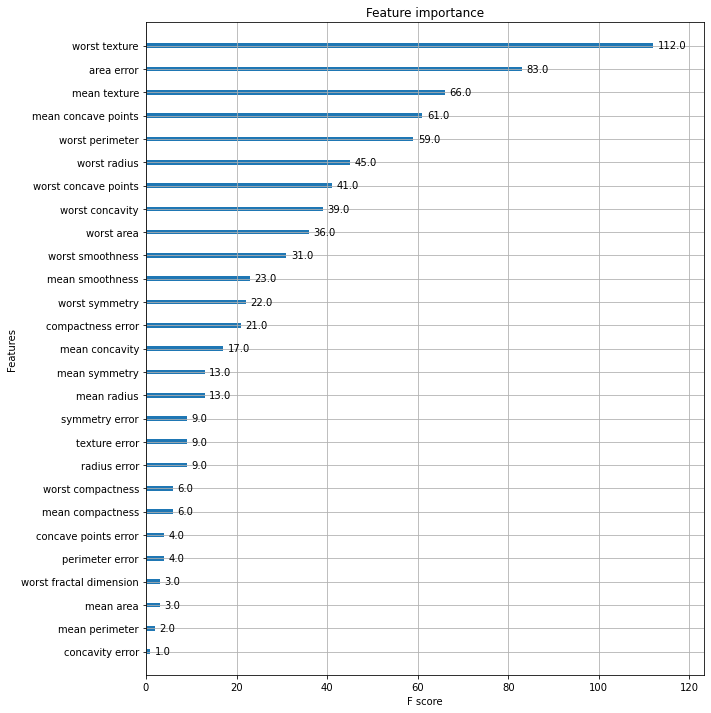

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(figsize=(10, 12))
plot_importance(xgb_model, ax=ax)

In [11]:
from xgboost import XGBClassifier

xgb_wrapper = XGBClassifier(n_estimators=400, learning_rate=0.05, max_depth=3, eval_metric='logloss')
xgb_wrapper.fit(X_train, y_train, verbose=True)
w_preds = xgb_wrapper.predict(X_test)
w_pred_proba = xgb_wrapper.predict_proba(X_test)[:, 1]

get_clf_eval(y_test, w_preds, w_pred_proba)

오차 행렬
[[34  3]
 [ 1 76]]
정확도: 0.9649, 정밀도: 0.9620, 재현율: 0.9870,    F1: 0.9744, AUC:0.9954


In [12]:
from xgboost import XGBClassifier

xgb_wrapper = XGBClassifier(n_estimators=400, learning_rate=0.05, max_depth=3)
evals = [(X_tr, y_tr), (X_val, y_val)]
xgb_wrapper.fit(X_tr, y_tr, early_stopping_rounds=50, eval_metric="logloss", 
                eval_set=evals, verbose=True)

ws50_preds = xgb_wrapper.predict(X_test)
ws50_pred_proba = xgb_wrapper.predict_proba(X_test)[:, 1]

[0]	validation_0-logloss:0.65016	validation_1-logloss:0.66183
[1]	validation_0-logloss:0.61131	validation_1-logloss:0.63609
[2]	validation_0-logloss:0.57563	validation_1-logloss:0.61144
[3]	validation_0-logloss:0.54310	validation_1-logloss:0.59204
[4]	validation_0-logloss:0.51323	validation_1-logloss:0.57329
[5]	validation_0-logloss:0.48447	validation_1-logloss:0.55037
[6]	validation_0-logloss:0.45796	validation_1-logloss:0.52929
[7]	validation_0-logloss:0.43436	validation_1-logloss:0.51534
[8]	validation_0-logloss:0.41150	validation_1-logloss:0.49718
[9]	validation_0-logloss:0.39027	validation_1-logloss:0.48154
[10]	validation_0-logloss:0.37128	validation_1-logloss:0.46990
[11]	validation_0-logloss:0.35254	validation_1-logloss:0.45474
[12]	validation_0-logloss:0.33528	validation_1-logloss:0.44229
[13]	validation_0-logloss:0.31893	validation_1-logloss:0.42961
[14]	validation_0-logloss:0.30439	validation_1-logloss:0.42065
[15]	validation_0-logloss:0.29000	validation_1-logloss:0.40958
[1

In [14]:
get_clf_eval(y_test, ws50_preds, ws50_pred_proba)

오차 행렬
[[34  3]
 [ 2 75]]
정확도: 0.9561, 정밀도: 0.9615, 재현율: 0.9740,    F1: 0.9677, AUC:0.9933


In [15]:
xgb_wrapper.fit(X_tr, y_tr, early_stopping_rounds=10, 
                eval_metric="logloss", eval_set=evals,verbose=True)

ws10_preds = xgb_wrapper.predict(X_test)
ws10_pred_proba = xgb_wrapper.predict_proba(X_test)[:, 1]
get_clf_eval(y_test , ws10_preds, ws10_pred_proba)

[0]	validation_0-logloss:0.65016	validation_1-logloss:0.66183
[1]	validation_0-logloss:0.61131	validation_1-logloss:0.63609
[2]	validation_0-logloss:0.57563	validation_1-logloss:0.61144
[3]	validation_0-logloss:0.54310	validation_1-logloss:0.59204
[4]	validation_0-logloss:0.51323	validation_1-logloss:0.57329
[5]	validation_0-logloss:0.48447	validation_1-logloss:0.55037
[6]	validation_0-logloss:0.45796	validation_1-logloss:0.52929
[7]	validation_0-logloss:0.43436	validation_1-logloss:0.51534
[8]	validation_0-logloss:0.41150	validation_1-logloss:0.49718
[9]	validation_0-logloss:0.39027	validation_1-logloss:0.48154
[10]	validation_0-logloss:0.37128	validation_1-logloss:0.46990
[11]	validation_0-logloss:0.35254	validation_1-logloss:0.45474
[12]	validation_0-logloss:0.33528	validation_1-logloss:0.44229
[13]	validation_0-logloss:0.31893	validation_1-logloss:0.42961
[14]	validation_0-logloss:0.30439	validation_1-logloss:0.42065
[15]	validation_0-logloss:0.29000	validation_1-logloss:0.40958
[1

In [16]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

card_df = pd.read_csv('./creditcard.csv')
card_df.head(3)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0


In [17]:
card_df.shape

(284807, 31)

In [18]:
from sklearn.model_selection import train_test_split

def get_preprocessed_df(df=None):
    df_copy = df.copy()
    df_copy.drop('Time', axis=1, inplace=True)
    return df_copy

In [19]:
def get_train_test_dataset(df=None):
    df_copy = get_preprocessed_df(df)
    
    X_features = df_copy.iloc[:, :-1]
    y_target = df_copy.iloc[:, -1]
    
    X_train, X_test, y_train, y_test = \
    train_test_split(X_features, y_target, test_size=0.3, random_state=0, stratify=y_target)
    
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)

y_train.value_counts()/y_train.shape[0]*100

0    99.827451
1     0.172549
Name: Class, dtype: float64

In [20]:
print('학습 데이터 레이블 값 비율')
print(y_train.value_counts()/y_train.shape[0] * 100)
print('테스트 데이터 레이블 값 비율')
print(y_test.value_counts()/y_test.shape[0] * 100)

학습 데이터 레이블 값 비율
0    99.827451
1     0.172549
Name: Class, dtype: float64
테스트 데이터 레이블 값 비율
0    99.826785
1     0.173215
Name: Class, dtype: float64


In [21]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score

def get_clf_eval(y_test, pred=None, pred_proba=None):
    confusion = confusion_matrix( y_test, pred)
    accuracy = accuracy_score(y_test , pred)
    precision = precision_score(y_test , pred)
    recall = recall_score(y_test , pred)
    f1 = f1_score(y_test,pred)
    roc_auc = roc_auc_score(y_test, pred_proba)
    print('오차 행렬')
    print(confusion)
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f},\
    F1: {3:.4f}, AUC:{4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))

In [22]:
from sklearn.linear_model import LogisticRegression

lr_clf = LogisticRegression(max_iter=1000)
lr_clf.fit(X_train, y_train)
lr_pred = lr_clf.predict(X_test)
lr_pred_proba = lr_clf.predict_proba(X_test)[:, 1]

get_clf_eval(y_test, lr_pred, lr_pred_proba)

오차 행렬
[[85281    14]
 [   57    91]]
정확도: 0.9992, 정밀도: 0.8667, 재현율: 0.6149,    F1: 0.7194, AUC:0.9700


In [31]:
def get_model_train_eval(model, ftr_train=None, ftr_test=None, tgt_train=None, tgt_test=None):
    model.fit(ftr_train, tgt_train)
    pred = model.predict(ftr_test)
    pred_proba = model.predict_proba(ftr_test)[:, 1]
    get_clf_eval(tgt_test, pred, pred_proba)

In [33]:
from lightgbm import LGBMClassifier

lgbm_clf = LGBMClassifier(n_estimators=1000, num_leaves=64, n_jobs=-1, boost_from_average=False)
get_model_train_eval(lgbm_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)

ModuleNotFoundError: No module named 'lightgbm'

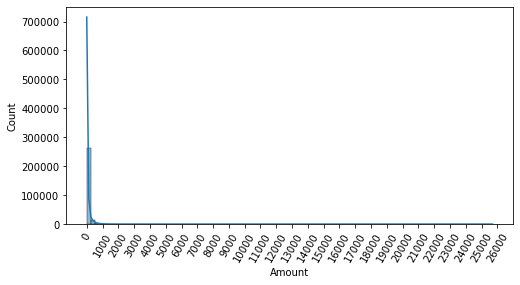

In [26]:
import seaborn as sns

plt.figure(figsize=(8, 4))
plt.xticks(range(0, 30000, 1000), rotation=60)
sns.histplot(card_df['Amount'], bins=100, kde=True)
plt.show()

In [27]:
from sklearn.preprocessing import StandardScaler

def get_preprocessed_df(df=None):
    df_copy = df.copy()
    scaler = StandardScaler()
    amount_n = scaler.fit_transform(df_copy['Amount'].values.reshape(-1, 1))
    df_copy.insert(0, 'Amount_Scaled', amount_n)
    df_copy.drop(['Time','Amount'], axis=1, inplace=True)
    return df_copy

In [28]:
X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)

print('### 로지스틱 회귀 예측 성능 ###')
lr_clf = LogisticRegression(max_iter=1000)
get_model_train_eval(lr_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)

print('### LightGBM 예측 성능 ###')
lgbm_clf = LGBMClassifier(n_estimators=1000, num_leaves=64, n_jobs=-1, boost_from_average=False)
get_model_train_eval(lgbm_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)

### 로지스틱 회귀 예측 성능 ###


NameError: name 'get_model_train_eval' is not defined

In [29]:
def get_preprocessed_df(df=None):
    df_copy = df.copy()
  
    amount_n = np.log1p(df_copy['Amount'])
    df_copy.insert(0, 'Amount_Scaled', amount_n)
    df_copy.drop(['Time','Amount'], axis=1, inplace=True)
    return df_copy

In [30]:
print(np.log(1e-1000))

-inf


In [31]:
import numpy as np

print(1e-1000 == 0.0)

print(np.log(1e-1000))

print(np.log(1e-1000 + 1))
print(np.log1p(1e-1000))

True
-inf
0.0
0.0


In [32]:
var_1 = np.log1p(100)
var_2 = np.expm1(var_1)
print(var_1, var_2)

4.61512051684126 100.00000000000003


In [33]:
X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)

print('### 로지스틱 회귀 예측 성능 ###')
get_model_train_eval(lr_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)

print('### LightGBM 예측 성능 ###')
get_model_train_eval(lgbm_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)

### 로지스틱 회귀 예측 성능 ###


NameError: name 'get_model_train_eval' is not defined

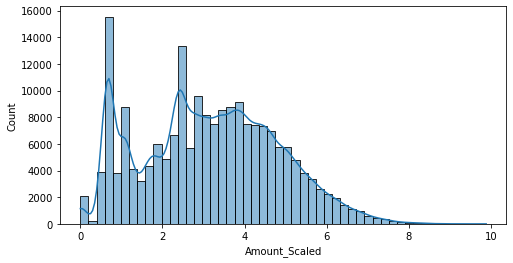

In [34]:
import seaborn as sns

plt.figure(figsize=(8, 4))
sns.histplot(X_train['Amount_Scaled'], bins=50, kde=True)
plt.show()

In [35]:
card_df.corr()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
Time,1.000000,1.173963e-01,-1.059333e-02,-4.196182e-01,-1.052602e-01,1.730721e-01,-6.301647e-02,8.471437e-02,-3.694943e-02,-8.660434e-03,...,4.473573e-02,1.440591e-01,5.114236e-02,-1.618187e-02,-2.330828e-01,-4.140710e-02,-5.134591e-03,-9.412688e-03,-0.010596,-0.012323
V1,0.117396,1.000000e+00,4.135835e-16,-1.227819e-15,-9.215150e-16,1.812612e-17,-6.506567e-16,-1.005191e-15,-2.433822e-16,-1.513678e-16,...,-2.457409e-16,-4.290944e-16,6.168652e-16,-4.425156e-17,-9.605737e-16,-1.581290e-17,1.198124e-16,2.083082e-15,-0.227709,-0.101347
V2,-0.010593,4.135835e-16,1.000000e+00,3.243764e-16,-1.121065e-15,5.157519e-16,2.787346e-16,2.055934e-16,-5.377041e-17,1.978488e-17,...,-8.480447e-17,1.526333e-16,1.634231e-16,1.247925e-17,-4.478846e-16,2.057310e-16,-4.966953e-16,-5.093836e-16,-0.531409,0.091289
V3,-0.419618,-1.227819e-15,3.243764e-16,1.000000e+00,4.711293e-16,-6.539009e-17,1.627627e-15,4.895305e-16,-1.268779e-15,5.568367e-16,...,5.706192e-17,-1.133902e-15,-4.983035e-16,2.686834e-19,-1.104734e-15,-1.238062e-16,1.045747e-15,9.775546e-16,-0.210880,-0.192961
V4,-0.105260,-9.215150e-16,-1.121065e-15,4.711293e-16,1.000000e+00,-1.719944e-15,-7.491959e-16,-4.104503e-16,5.697192e-16,6.923247e-16,...,-1.949553e-16,-6.276051e-17,9.164206e-17,1.584638e-16,6.070716e-16,-4.247268e-16,3.977061e-17,-2.761403e-18,0.098732,0.133447
V5,0.173072,1.812612e-17,5.157519e-16,-6.539009e-17,-1.719944e-15,1.000000e+00,2.408382e-16,2.715541e-16,7.437229e-16,7.391702e-16,...,-3.920976e-16,1.253751e-16,-8.428683e-18,-1.149255e-15,4.808532e-16,4.319541e-16,6.590482e-16,-5.613951e-18,-0.386356,-0.094974
V6,-0.063016,-6.506567e-16,2.787346e-16,1.627627e-15,-7.491959e-16,2.408382e-16,1.000000e+00,1.191668e-16,-1.104219e-16,4.131207e-16,...,5.833316e-17,-4.705235e-19,1.046712e-16,-1.071589e-15,4.562861e-16,-1.357067e-16,-4.452461e-16,2.594754e-16,0.215981,-0.043643
V7,0.084714,-1.005191e-15,2.055934e-16,4.895305e-16,-4.104503e-16,2.715541e-16,1.191668e-16,1.000000e+00,3.344412e-16,1.122501e-15,...,-2.027779e-16,-8.898922e-16,-4.387401e-16,7.434913e-18,-3.094082e-16,-9.657637e-16,-1.782106e-15,-2.776530e-16,0.397311,-0.187257
V8,-0.036949,-2.433822e-16,-5.377041e-17,-1.268779e-15,5.697192e-16,7.437229e-16,-1.104219e-16,3.344412e-16,1.000000e+00,4.356078e-16,...,3.892798e-16,2.026927e-16,6.377260e-17,-1.047097e-16,-4.653279e-16,-1.727276e-16,1.299943e-16,-6.200930e-16,-0.103079,0.019875
V9,-0.008660,-1.513678e-16,1.978488e-17,5.568367e-16,6.923247e-16,7.391702e-16,4.131207e-16,1.122501e-15,4.356078e-16,1.000000e+00,...,1.936953e-16,-7.071869e-16,-5.214137e-16,-1.430343e-16,6.757763e-16,-7.888853e-16,-6.709655e-17,1.110541e-15,-0.044246,-0.097733


<AxesSubplot:>

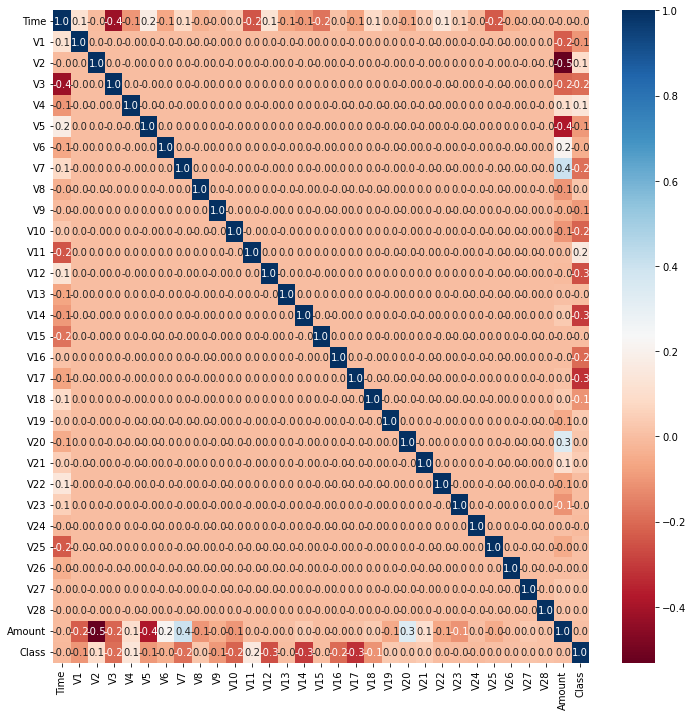

In [36]:
import seaborn as sns

plt.figure(figsize=(12, 12))
corr = card_df.corr()
sns.heatmap(corr, annot=True, fmt='.1f',  cmap='RdBu')

In [37]:
import numpy as np

def get_outlier(df=None, column=None, weight=1.5):

    fraud = df[df['Class']==1][column]
    quantile_25 = np.percentile(fraud.values, 25)
    quantile_75 = np.percentile(fraud.values, 75)

    iqr = quantile_75 - quantile_25
    iqr_weight = iqr * weight
    lowest_val = quantile_25 - iqr_weight
    highest_val = quantile_75 + iqr_weight

    outlier_index = fraud[(fraud < lowest_val) | (fraud > highest_val)].index
    return outlier_index

In [38]:
np.percentile(card_df['V14'].values, 75)

0.493149849218149

In [39]:
np.percentile(card_df['V14'].values, 100)
np.max(card_df['V14'].values)
quantile_25 = np.percentile(card_df['V14'].values, 25)
quantile_75 = np.percentile(card_df['V14'].values, 75)
print(quantile_25, quantile_75)

-0.4255740124549935 0.493149849218149


In [40]:
outlier_index = get_outlier(df=card_df, column='V14', weight=1.5)
print('이상치 데이터 인덱스:', outlier_index)

이상치 데이터 인덱스: Int64Index([8296, 8615, 9035, 9252], dtype='int64')


In [41]:
def get_preprocessed_df(df=None):
    df_copy = df.copy()
    amount_n = np.log1p(df_copy['Amount'])
    df_copy.insert(0, 'Amount_Scaled', amount_n)
    df_copy.drop(['Time','Amount'], axis=1, inplace=True)
    # 이상치 데이터 삭제하는 로직 추가
    outlier_index = get_outlier(df=df_copy, column='V14', weight=1.5)
    df_copy.drop(outlier_index, axis=0, inplace=True)
    return df_copy

X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)
print('### 로지스틱 회귀 예측 성능 ###')
get_model_train_eval(lr_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)
print('### LightGBM 예측 성능 ###')
get_model_train_eval(lgbm_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)

### 로지스틱 회귀 예측 성능 ###


NameError: name 'get_model_train_eval' is not defined

In [42]:
import imblearn

print(imblearn.__version__)

ModuleNotFoundError: No module named 'imblearn'

In [43]:
y_train.value_counts()

0    199020
1       342
Name: Class, dtype: int64

In [44]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=0)
X_train_over, y_train_over = smote.fit_resample(X_train, y_train)
print('SMOTE 적용 전 학습용 피처/레이블 데이터 세트: ', X_train.shape, y_train.shape)
print('SMOTE 적용 후 학습용 피처/레이블 데이터 세트: ', X_train_over.shape, y_train_over.shape)
print('SMOTE 적용 후 레이블 값 분포: \n', pd.Series(y_train_over).value_counts())

ModuleNotFoundError: No module named 'imblearn'

In [45]:
lr_clf = LogisticRegression(max_iter=1000)
get_model_train_eval(lr_clf, ftr_train=X_train_over, ftr_test=X_test, tgt_train=y_train_over, tgt_test=y_test)

NameError: name 'get_model_train_eval' is not defined

In [46]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.metrics import precision_recall_curve
%matplotlib inline

def precision_recall_curve_plot(y_test , pred_proba_c1):
    precisions, recalls, thresholds = precision_recall_curve( y_test, pred_proba_c1)
    
    plt.figure(figsize=(8,6))
    threshold_boundary = thresholds.shape[0]
    plt.plot(thresholds, precisions[0:threshold_boundary], linestyle='--', label='precision')
    plt.plot(thresholds, recalls[0:threshold_boundary],label='recall')
    
    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1),2))
    
    plt.xlabel('Threshold value'); plt.ylabel('Precision and Recall value')
    plt.legend(); plt.grid()
    plt.show()

In [47]:
precision_recall_curve_plot( y_test, lr_clf.predict_proba(X_test)[:, 1] )

NotFittedError: This LogisticRegression instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

In [48]:
lgbm_clf = LGBMClassifier(n_estimators=1000, num_leaves=64, n_jobs=-1, boost_from_average=False)
get_model_train_eval(lgbm_clf, ftr_train=X_train_over, ftr_test=X_test,
                  tgt_train=y_train_over, tgt_test=y_test)

NameError: name 'LGBMClassifier' is not defined